In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [2]:
import os
import numpy as np
import cv2
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, InputLayer, Lambda
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

In [81]:
# from google.colab import drive
# drive.mount('/content/drive/')


## Data Reading

In [3]:
# Read inputs and images
images = []
labels = []
dataset = 'vehicle_dataset'

for folder in os.listdir(dataset):
    if not folder.startswith('.'):
        label = None

        if folder in ['vehicles']: label = 0
        elif folder in ['non-vehicles']: label = 1

        for file in os.listdir(os.path.join(dataset, folder)):
            if file.endswith('.png'):
                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)

                images.append(image)
                labels.append(label)

images = np.array(images, dtype='float32')/255.0
labels = np.array(labels, dtype='int32')

images = images.reshape(-1,64,64,3)

images, labels = shuffle(images, labels, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [4]:
images[0].shape

(64, 64, 3)

## Data Preprocessing

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(X_train)

## Model Defining

In [44]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(24, (3, 3), padding="same", input_shape=(64, 64, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(48, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(60, (3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss='binary_crossentropy', optimizer=opt ,metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 24)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 13, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 13, 13, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 60)       │        25,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 60)       │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 4, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │        12,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,225 (235.25 KB)

 Trainable params: 59,897 (233.97 KB)

 Non-trainable params: 328 (1.28 KB)

In [45]:
history = model.fit(datagen.flow(X_train, y_train),
                    epochs=50,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.8149 - loss: 0.3869 - precision_1: 0.8233 - recall_1: 0.8074 - val_accuracy: 0.5242 - val_loss: 1.1040 - val_precision_1: 0.5089 - val_recall_1: 1.0000
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9413 - loss: 0.1488 - precision_1: 0.9365 - recall_1: 0.9489 - val_accuracy: 0.9761 - val_loss: 0.0678 - val_precision_1: 0.9832 - val_recall_1: 0.9680
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9601 - loss: 0.1040 - precision_1: 0.9528 - recall_1: 0.9693 - val_accuracy: 0.9713 - val_loss: 0.0868 - val_precision_1: 0.9464 - val_recall_1: 0.9983
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9672 - loss: 0.0931 - precision_1: 0.9649 - recall_1: 0.9703 - val_accuracy: 0.9845 - val_loss: 0.0418 - val_precision_1: 0.9930 - val_recall_1: 0.9754
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9733 - loss: 0.0720 - precision_1: 0.9707 - recall_1

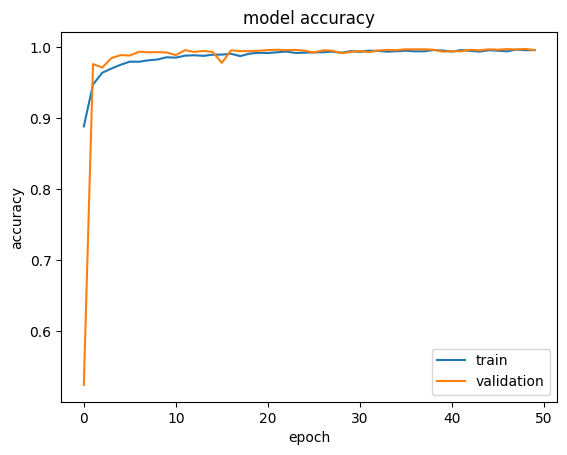

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

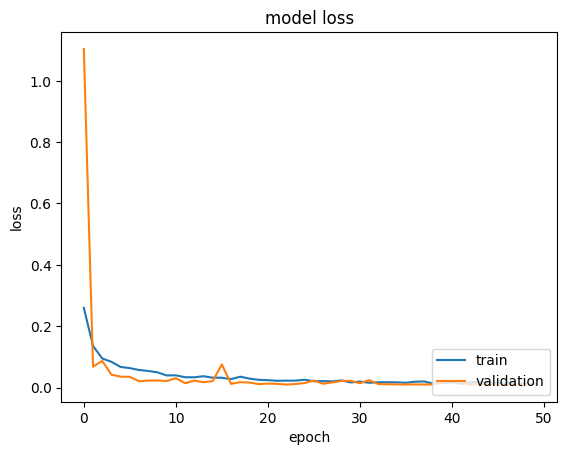

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Prediction: Vehicle


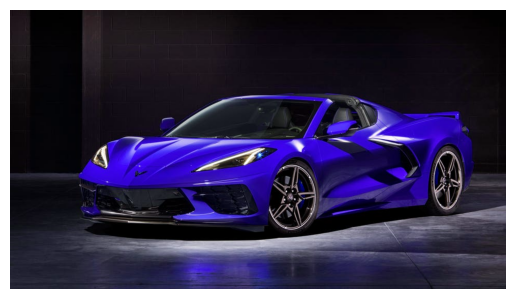

In [48]:
img_path = 'test.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (64, 64))  # Resize image to match input size of your model
img_array = img.astype(np.float32) / 255.0  # Normalize pixel values to range [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

predictions = model.predict(img_array)

# Interpret the predictions
if predictions[0][0] > 0.5:
    print("Prediction: Not vehicle")
else:
    print("Prediction: Vehicle")

plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()

In [51]:

# Test the model
y_pred = model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [52]:
accuracy = accuracy_score(y_test, y_pred>0.5)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')
print(f'ROC_AUC: {roc_auc:.3f}')



Accuracy: 0.996
ROC_AUC: 1.000


## Pretrained Models

*MobileNet50*

In [19]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('vehicle_dataset', batch_size=BATCH_SIZE, image_size=IMG_SIZE, labels='inferred', validation_split=0.2, subset='training', seed=42)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('vehicle_dataset', batch_size=BATCH_SIZE, image_size=IMG_SIZE, labels='inferred', validation_split=0.2, subset='validation', seed=42)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input



Found 17760 files belonging to 2 classes.
Using 14208 files for training.
Found 17760 files belonging to 2 classes.
Using 3552 files for validation.
Number of validation batches: 89
Number of test batches: 22


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
image_batch, label_batch = next(iter(train_dataset))
feature_batch = baseModel(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [21]:
baseModel.trainable = False

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [23]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [26]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = preprocess_input(inputs)
x = baseModel(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 256, 256)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 256, 256)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, 256, 256)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_5 (Stack)     │ (None, 256, 256,  │          0 │ get_item_15[0][0… │
│                     │ 3)                │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256, 256,  │          0 │ stack_5[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add_5[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      2,049 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [28]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

89/89 ━━━━━━━━━━━━━━━━━━━━ 88s 976ms/step - accuracy: 0.5797 - loss: 0.8136


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.8543 - loss: 0.3549 - val_accuracy: 0.9940 - val_loss: 0.0546
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.9920 - loss: 0.0537 - val_accuracy: 0.9958 - val_loss: 0.0278
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.9952 - loss: 0.0291 - val_accuracy: 0.9965 - val_loss: 0.0183
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.9971 - loss: 0.0195 - val_accuracy: 0.9972 - val_loss: 0.0141
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.9975 - loss: 0.0151 - val_accuracy: 0.9975 - val_loss: 0.0113
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.9984 - loss: 0.0116 - val_accuracy: 0.9986 - val_loss: 0.0084
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.9987 - loss: 0.0098 - val_accuracy: 0.9996 - val_loss: 0.0067
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.9993 - loss: 0.0081 - val_accu

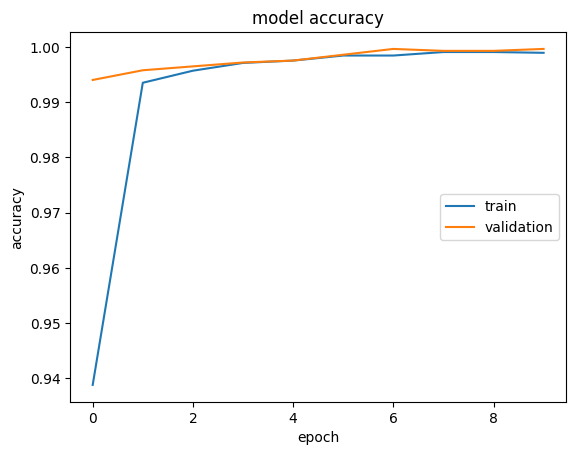

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="right")
plt.show()

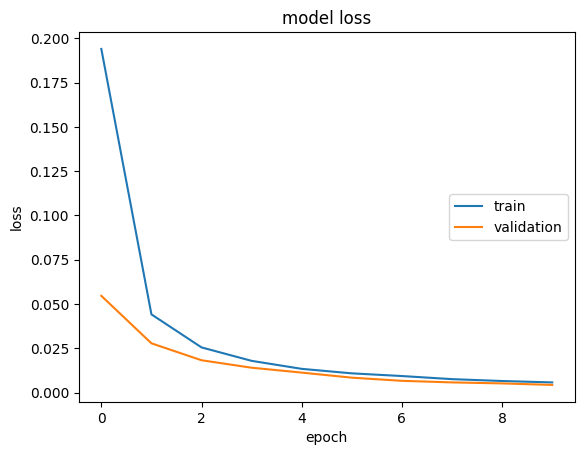

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="right")
plt.show()

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9999 - loss: 0.0033
Test accuracy : 0.9985795617103577


Predictions:
 [1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1]
Labels:
 [1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1]


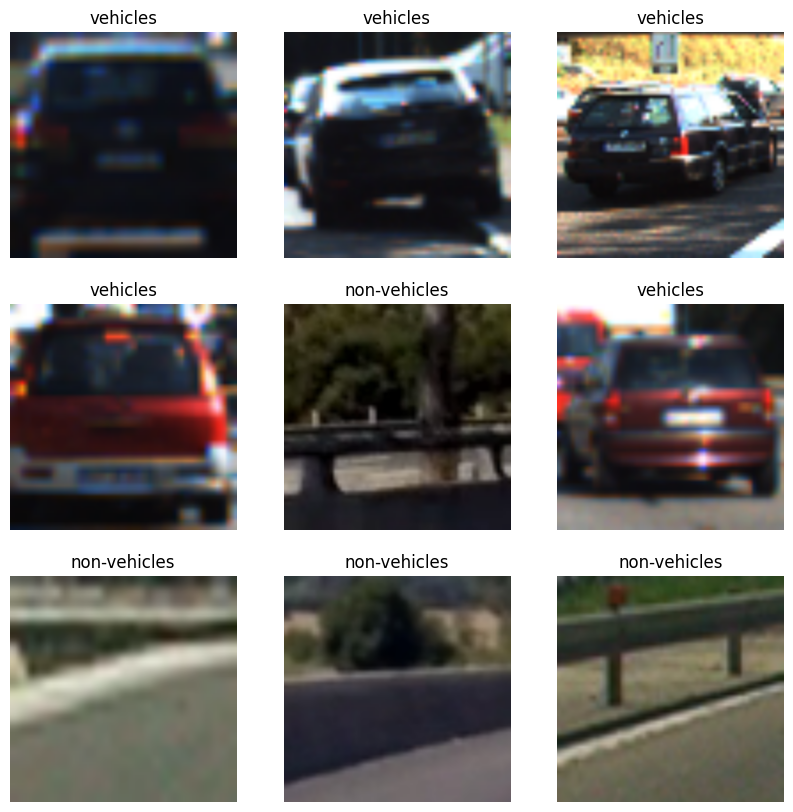

In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.6, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(train_dataset.class_names[predictions[i]])
  plt.axis("off")